<a href="https://colab.research.google.com/github/Nehil971/Satge_L3/blob/master/D%C3%A9but_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U bindsnet

Requirement already up-to-date: bindsnet in /usr/local/lib/python3.6/dist-packages (0.2.6)


In [0]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from bindsnet.models import DiehlAndCook2015v2
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.datasets import MNIST, DataLoader
from bindsnet.encoding import PoissonEncoder
from torchvision import transforms
from tqdm import tqdm
from bindsnet.utils import get_square_weights
from bindsnet import ROOT_DIR

In [0]:
import torch
import numpy as np
from bindsnet import encoding
from torchvision import transforms
import glob
from PIL import Image
from numpy import max
import matplotlib.pyplot as plt
from tqdm import tqdm
from bindsnet.models import DiehlAndCook2015v2
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

In [0]:
def single(
        datum: torch.Tensor, time: int, dt: float = 1.0, min : float = 0, max : float = 255.0, **kwargs
) -> torch.Tensor:
    # language=rst
    """
    Generates timing based single-spike encoding. Spike occurs earlier if the
    intensity of the input feature is higher. Features whose value is lower than
    threshold is remain silent.

    :param datum: Tensor of shape ``[n_1, ..., n_k]``.
    :param time: Length of the input and output.
    :param dt: Simulation time step.
    :param sparsity: Sparsity of the input representation. 0 for no spikes and 1 for all
        spikes.
    :return: Tensor of shape ``[time, n_1, ..., n_k]``.
    """
    # [Min, Max] découpé en time intervals
    time = int(time / dt)
    shape = list(datum.shape)
    datum = np.copy(datum)
    s = np.zeros([time, *shape])
    s[0] = np.zeros(shape)
    dv = np.float((max-min)/time)
    v = np.float(max)-dv
    for t in range(time):
        mask = (datum >= v)
        #s[t] = np.where((v - dv) < datum <= v, np.ones(shape), np.zeros(shape))
        s[t] = np.where(mask, np.ones(shape), np.zeros(shape))
        v -= dv
        datum[mask] = min-1

    return torch.Tensor(s).byte()

def normalisation(data : torch.Tensor ,min : float = 0.0, max : float = 255.0):
    min2 = torch.min(data)
    max2 = torch.max(data)
    data = (data - min2) / (max2 - min2) * (max-min) + min

    return data

def LoadImg(Chemin : str, bandes : int, length : int, width : int):
  images = glob.glob(Chemin+"/*jpg")

  imtens = torch.Tensor(len(images), bandes, length, width)
  i =0
  for image in images :
    img = Image.open(image)

    ## Modification img si besoin
    if img.height != length or img.width != width:
      img = transforms.Resize((length,width))(img)
    img = transforms.Grayscale(1)(img)
    imtens[i] = transforms.ToTensor()(img)*255

    ## Modification du bandes, de 3 vers 1:
    if imtens.size(0) > bandes:
      #img = transforms.Grayscale(1)(img)
      imtens[i] = transforms.ToTensor()(img)*255

    ## Modification du bandes, de 1 vers 3:
    if imtens.size(0) < bandes:
      img = transforms.Grayscale(3)(img)
      imtens[i] = transforms.ToTensor()(img)*255
    i +=1
  return imtens

In [0]:
batch_size = 32
update_steps = 256
time = 250
dt = 1.0
seed = 0
plot = True
gpu = False
n_neurons = 30
n_workers = 0
intensity = 128
n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
update_interval = update_steps * batch_size

  0%|          | 0/1875 [00:00<?, ?it/s]

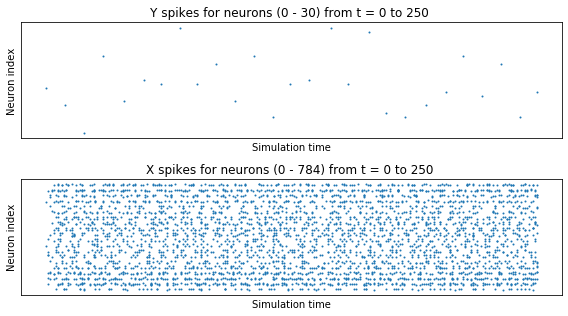

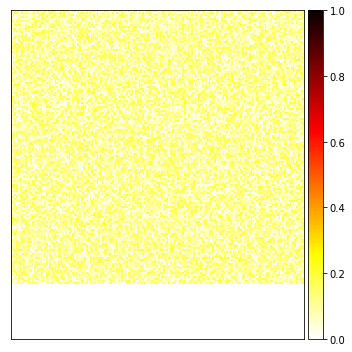

  0%|          | 1/1875 [00:01<54:40,  1.75s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 2/1875 [00:02<49:28,  1.58s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 3/1875 [00:04<45:49,  1.47s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 4/1875 [00:05<43:30,  1.40s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 5/1875 [00:06<41:40,  1.34s/it]

<Figure size 432x288 with 0 Axes>

  0%|          | 6/1875 [00:07<40:21,  1.30s/it]


KeyboardInterrupt: ignored

In [32]:
torch.manual_seed(seed)

# Build Diehl & Cook 2015 network.
network = DiehlAndCook2015v2(
    n_inpt=784,
    n_neurons=n_neurons,
    inh=17.5,
    dt=1.0,
    norm=78.4,
    inpt_shape=(1, 28, 28),
)

# Specify dataset
mnist_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join(ROOT_DIR, "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)



mnist_dataloader = DataLoader(
        mnist_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers,
        pin_memory=gpu,
    )




# Create and add monitor on recurent layer
#rec_layer = network.layers["Y"]
#rec_monitor = Monitor(
#    obj=rec_layer,
#    state_vars=["v"],  # Record spikes and voltages.
#    time=time,  # Length of simulation (if known ahead of time).
#)
#network.add_monitor(monitor=rec_monitor, name="Y_voltage")

spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=time)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

spike_record = torch.zeros(update_interval, time, n_neurons)

inpt_ims, inpt_axes = None, None
spike_ims, spike_axes = None, None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes, voltage_ims = None, None


for step, batch in enumerate(tqdm(mnist_dataloader)):
    # Get next input sample.

    inpts = {"X": batch["encoded_image"]}

    # Run the network on the input.
    network.run(inputs=inpts, time=time, input_time_dim=1)


    # Optionally plot various simulation information.
    s = spikes["Y"].get("s").permute((1, 0, 2))
    spike_record[
    (step * batch_size)
    % update_interval: (step * batch_size % update_interval)
                       + s.size(0)
    ] = s

    # Get voltage recording.
    #rec_voltages = rec_monitor.get("v")
    #rec_spikes = rec_monitor.get("v")

    if plot:
        weights = network.connections[("X", "Y")].w
        square_weights = get_square_weights(
            weights.view(784, n_neurons), n_sqrt, 28
        )
        spikes_ = {
            layer: spikes[layer].get("s")[:, 0].contiguous() for layer in spikes
        }
        spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
        weights_im = plot_weights(square_weights, im=weights_im)

        plt.pause(1e-8)

    network.reset_state_variables()  # Reset state variables. #network.reset_st

In [35]:
torch.manual_seed(seed)

imtens = LoadImg("img",1, 28, 28)
data_encod = single(datum = imtens,time = time, dt = dt,sparsity=0.5)
inpts = {"X": data_encod}

# Run the network on the input.
network.learning = False
network.run(inputs=inpts, time=time, input_time_dim=1)

# Optionally plot various simulation information.
s = spikes["Y"].get("s").permute((1, 0, 2))
spike_record[
(step * batch_size)
% update_interval: (step * batch_size % update_interval)
                    + s.size(0)
] = s

# Get voltage recording.
#rec_voltages = rec_monitor.get("v")
#rec_spikes = rec_monitor.get("v")

if plot:
    weights = network.connections[("X", "Y")].w
    square_weights = get_square_weights(
        weights.view(784, n_neurons), n_sqrt, 28
    )
    spikes_ = {
        layer: spikes[layer].get("s")[:, 0].contiguous() for layer in spikes
    }
    spike_ims, spike_axes = plot_spikes(spikes_, ims=spike_ims, axes=spike_axes)
    weights_im = plot_weights(square_weights, im=weights_im)

    plt.pause(1e-8)

<Figure size 432x288 with 0 Axes>